In [2]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
with open('data/train.json', 'r') as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [4]:
df = pd.DataFrame(data['annotations'])
print(df.shape)
df.head()

(15774, 8)


,segmentation,area,iscrowd,image_id,bbox,category_id,id,ignore
0,"[[52, 86, 52, 420, 471, 420, 471, 86]]",139946,0,2008000008,"[52, 86, 419, 334]",13,1,0
1,"[[157, 43, 157, 167, 289, 167, 289, 43]]",16368,0,2008000008,"[157, 43, 132, 124]",15,2,0
2,"[[269, 0, 269, 176, 378, 176, 378, 0]]",19184,0,2008000015,"[269, 0, 109, 176]",5,3,0
3,"[[56, 0, 56, 150, 164, 150, 164, 0]]",16200,0,2008000015,"[56, 0, 108, 150]",5,4,0
4,"[[138, 1, 138, 197, 372, 197, 372, 1]]",45864,0,2008000019,"[138, 1, 234, 196]",12,5,0


In [5]:
df.iscrowd.value_counts(), df.ignore.value_counts()

(iscrowd
 0    15774
 Name: count, dtype: int64,
 ignore
 0    13609
 1     2165
 Name: count, dtype: int64)

In [11]:
id2label = {d['id']:d['name'] for d in data['categories']}
len(id2label)

20

In [12]:
id2img = {d['id']:'data/train/'+d['file_name'] for d in data['images']}

In [14]:
df = df.query('ignore!=1').drop(columns=['segmentation','ignore'])
agg_df = df.groupby('image_id').agg(list).reset_index()

In [48]:
img_id, gtbbs, cat_ids = agg_df.loc[3,['image_id','bbox','category_id']]

In [6]:
def show_bbs(img_path, bboxes, labels=None):
    img = plt.imread(img_path)
    _, ax = plt.subplots(1)
    ax.imshow(img)
    for i, bbox in enumerate(bboxes):
        xmin, ymin, w, h = bbox
        rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(xmin+5, ymin+10, labels[i], color='black', fontsize=8, backgroundcolor='white')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

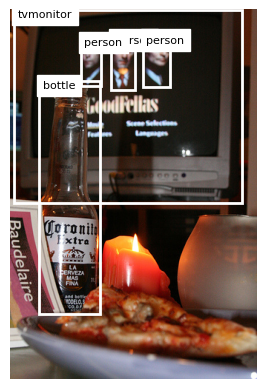

In [49]:
img_path = id2img[img_id]
labels = [id2label[cat_id] for cat_id in cat_ids]

show_bbs(img_path, gtbbs, labels)

In [24]:
with open('data/valid.json', 'r') as f:
    valid_data = json.load(f)

valid_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [3]:
def load_data(ann_folder, imgs_folder, split='train'):
    ann_folder, imgs_folder = Path(ann_folder), Path(imgs_folder)
    data = json.load((ann_folder/f'{split}.json').open())

    id2label = {d['id']:d['name'] for d in data['categories']}
    id2img = {d['id']:imgs_folder/d['file_name'] for d in data['images']}

    df = pd.DataFrame(data['annotations'])
    df = df.query('ignore!=1').drop(columns=['segmentation','ignore'])
    agg_df = df.groupby('image_id').agg(list).reset_index()
    return agg_df, id2label, id2img

In [4]:
agg_df, id2label, id2img = load_data(ann_folder='data', imgs_folder='data/train')

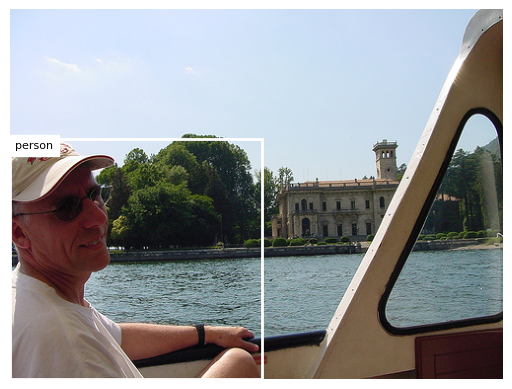

In [7]:
img_id, gtbbs, cat_ids = agg_df.loc[100, ['image_id','bbox','category_id']]
img_path = id2img[img_id]
labels = [id2label[id] for id in cat_ids]

show_bbs(img_path, gtbbs, labels)

In [1]:
def make_json_file(path, df):
    ann_data = [
        {'id':id, 'image_id':row['image_id'], 'bbox':bbox, 'category_id':cat_id,
         'iscrowd':iscrowd, 'area':area, 'ignore':0, 'segmentation':[]}
        for _, row in df.iterrows()
        for id, bbox, cat_id, area, iscrowd in zip(*row[['id','bbox','category_id','area','iscrowd']])
    ]
    imgs_data = [{'id':k, 'file_name':v.name} for k,v in id2img.items()]
    cat_data = [{'id':k, 'name':v} for k,v in id2label.items()]
    
    with open(path, 'w') as f:
        json.dump({'categories':cat_data,'annotations':ann_data,'images':imgs_data}, f, indent=4)

In [5]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(agg_df, test_size=0.1)

In [6]:
make_json_file('tmp/train.json', train_df)

make_json_file('tmp/valid.json', valid_df)